## Setup...

In [1]:
# Various setup, probably mostly unused

from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
from bart.sched.SchedMultiAssert import SchedMultiAssert
import pandas as pd
from trace import Trace
LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
logging.getLogger('EnergyMeter').setLevel(logging.DEBUG)
%matplotlib inline
from platforms.juno_energy import juno_energy
from platforms.pixel_energy import pixel_energy
import tests.eas.generic
import numpy as np
from IPython.display import display
from wlgen import RTA, Periodic
from executor import Executor
from platforms.hikey_energy import hikey_energy
import numpy as np

2017-03-15 12:37:56,394 INFO    : root         : Using LISA logging configuration:
2017-03-15 12:37:56,395 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
# Some nonsense to get caiman to work on Brendan's computer
p = os.getenv('PATH').split(':')
caiman_path = '/opt/ds5_v5.23.0/bin'
if caiman_path not in p:
    p.insert(0, caiman_path)
    os.environ['PATH'] = ':'.join(p)

In [3]:
te = TestEnv(test_conf={
        'modules': ['cgroups'], 
        'ftrace': {
            'events': ['sched_switch', 'cpu_frequency', 'cpu_idle', 'sched_load_avg_cpu', 'sched_load_avg_task', 'irq*']
        }
    }, force_new=True)

2017-03-15 12:37:56,437 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-03-15 12:37:56,438 INFO    : TestEnv      : Loading default (file) target configuration
2017-03-15 12:37:56,439 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-03-15 12:37:56,442 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-03-15 12:37:56,442 INFO    : TestEnv      : External tools using:
2017-03-15 12:37:56,443 INFO    : TestEnv      :    ANDROID_HOME: /work/android-sdk-linux
2017-03-15 12:37:56,444 INFO    : TestEnv      :    CATAPULT_HOME: /home/brejac01/sources/lisa/tools/catapult
2017-03-15 12:37:56,445 INFO    : TestEnv      : Devlib modules to load: ['cpuidle', 'cpufreq', 'cgroups']
2017-03-15 12:37:56,446 INFO    : TestEnv      : Connecting Android target [04D314DF000BC57F]
2017-03-15 12:37:56,447 INFO    : TestEnv      : Connection settings:
2017-03-15 12:37:56,448 INFO    : TestEnv      :    {'

In [4]:
# Some nonsense to make LISA treat HiKey with the respect it deserves
from trappy.stats.Topology import Topology
hikey_topology = Topology(clusters=[[0, 1, 2, 3], [4, 5, 6, 7]])
te.topology = hikey_topology
te.platform['clusters'] = {'big': [0, 1, 2, 3], 'little': [4, 5, 6, 7]}

# Define Workloads
We're going to create two workloads with a handful of small tasks, such that they could fit onto a single cluster at the lowest OPP. 

To avoid evertying being thrown out by the periodiciy of the tasks, the start times and periods of the tasks are staggered.

We'll run this same workload both with and without using taskset to force them onto a single cluster.

In [5]:
def get_wloads(nrg_model, cpu=0, type='min', bandwidth_to_eat=0.75, ntasks=16):
    cpu_node = nrg_model.cpu_nodes[cpu]
    cluster_node = cpu_node.parent
    ncpus = len(cluster_node.cpus)
    if type == 'min':
        cpu_cap = cpu_node.min_capacity
    elif type == 'max':
        cpu_cap = cpu_node.max_capacity
        
    total_cap = bandwidth_to_eat * ncpus * cpu_cap
    target_task_cap = total_cap / ntasks
    task_pct = int((target_task_cap / 1024) * 100)
    task_cap = int(1024 * (task_pct / 100.))
    tasks_per_cpu = int(cpu_cap / task_cap)
    
    print 'Will create workloads with {} tasks each using {} capacity'.format(ntasks, task_cap)
    
    # Stagger the workloads so that they prevent shared idle states
    period_s = 10e-3
    stagger_s = 0.7e-3
    delays = np.arange(period_s, step=stagger_s)
    
    if len(delays) > ntasks:
        print "WARNING: not enough tasks to cover period with wakeups"
    
    tasks = {}
    for i in range(ntasks):
        tasks['{}pct_{}'.format(task_pct, i)] = {
            'kind': 'Periodic',
            'params': {
                'duty_cycle_pct': task_pct,
                'period_ms' : period_s * 1e3 + (i - (ntasks / 2)),
                'delay_s' : delays[i % len(delays)],
                'duration_s': 2
            }
        }
    
    wloads = {
        'forced_pack': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': [0, 1, 2, 3],
                'duration': 5,
            }
        },
        'break_packing': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': [2, 3, 4, 5],
                'duration': 5,
            }
        }
    }
        
    return wloads

In [6]:
wloads = get_wloads(hikey_energy, type='max')

Will create workloads with 16 tasks each using 184 capacity


# Run workloads
Now we'll run the workloads with the powersave governor

In [7]:
executor = Executor(te, {
        'confs': [{
            'tag': 'freq_{}'.format(freq),
            'flags': ['ftrace', 'freeze_userspace'],
            'cpufreq': {
                'governor': 'userspace',
                'freqs': {
                   0: freq
                }
            },
        } for freq in te.target.cpufreq.list_frequencies(0)],
        'wloads': wloads,
        'iterations': 5
    })

2017-03-15 12:38:37,852 INFO    : Executor     : Loading custom (inline) test configuration
2017-03-15 12:38:37,853 INFO    : Executor     : 
2017-03-15 12:38:37,854 INFO    : Executor     : ################################################################################
2017-03-15 12:38:37,855 INFO    : Executor     : Experiments configuration
2017-03-15 12:38:37,856 INFO    : Executor     : ################################################################################
2017-03-15 12:38:37,857 INFO    : Executor     : Configured to run:
2017-03-15 12:38:37,858 INFO    : Executor     :      5 target configurations:
2017-03-15 12:38:37,859 INFO    : Executor     :       freq_208000, freq_432000, freq_729000, freq_960000, freq_1200000
2017-03-15 12:38:37,860 INFO    : Executor     :      2 workloads (5 iterations each)
2017-03-15 12:38:37,861 INFO    : Executor     :       break_packing, forced_pack
2017-03-15 12:38:37,862 INFO    : Executor     : Total: 50 experiments
2017-03-15 12:38:

In [8]:
executor.run()

2017-03-15 12:38:48,190 INFO    : Executor     : 
2017-03-15 12:38:48,192 INFO    : Executor     : ################################################################################
2017-03-15 12:38:48,193 INFO    : Executor     : Experiments execution
2017-03-15 12:38:48,194 INFO    : Executor     : ################################################################################
2017-03-15 12:38:48,196 INFO    : Executor     : 
2017-03-15 12:38:48,197 INFO    : Executor     : ================================================================================
2017-03-15 12:38:48,198 INFO    : Executor     : configuring target for [freq_208000] experiments
2017-03-15 12:38:49,600 WARNING : Executor     : Setting target SELinux in permissive mode
2017-03-15 12:38:50,374 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2017-03-15 12:38:51,127 INFO    : Executor     :        CPUFreq - CPU frequencies: {0: 208000}
2017-03-15 12:38:52,912 WARNING : TestEnv      : 

2017-03-15 12:39:45,638 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.165521
2017-03-15 12:40:08,348 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:40:08,350 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace.dat
2017-03-15 12:40:08,352 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:40:08,353 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace_stat.json
2017-03-15 12:40:08,354 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:40:11,873 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:40:11,875 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:40:11,876 INFO    : Executor     : Experiment 1/50, [freq_208000:break_packing] 2/5
2017-03-15 12:40:12,138 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 12:41:01,745 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.165628
2017-03-15 12:41:24,263 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:41:24,265 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace.dat
2017-03-15 12:41:24,267 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:41:24,268 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace_stat.json
2017-03-15 12:41:24,269 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:41:27,844 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:41:27,846 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:41:27,847 INFO    : Executor     : Experiment 2/50, [freq_208000:break_packing] 3/5
2017-03-15 12:41:28,141 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 12:42:17,630 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.165735
2017-03-15 12:42:39,619 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:42:39,621 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace.dat
2017-03-15 12:42:39,622 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:42:39,623 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace_stat.json
2017-03-15 12:42:39,625 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:42:43,212 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:42:43,214 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:42:43,215 INFO    : Executor     : Experiment 3/50, [freq_208000:break_packing] 4/5
2017-03-15 12:42:43,510 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 12:43:33,597 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.166331
2017-03-15 12:43:55,989 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:43:55,991 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace.dat
2017-03-15 12:43:55,992 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:43:55,994 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace_stat.json
2017-03-15 12:43:55,995 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:43:59,699 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:43:59,701 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:43:59,702 INFO    : Executor     : Experiment 4/50, [freq_208000:break_packing] 5/5
2017-03-15 12:43:59,975 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 12:44:49,989 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.167286
2017-03-15 12:45:12,182 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:45:12,184 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace.dat
2017-03-15 12:45:12,185 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:45:12,186 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace_stat.json
2017-03-15 12:45:12,187 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:45:15,766 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:45:15,769 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 12:45:16,206 WARNING : Workload     : Limiting workload duration to 5 [s]
2017-03-15 12:45:16,208 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 12:45:16,209 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 12:46:06,716 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.167190
2017-03-15 12:46:29,255 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:46:29,257 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace.dat
2017-03-15 12:46:29,258 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:46:29,259 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace_stat.json
2017-03-15 12:46:29,260 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:46:32,895 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:46:32,898 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:46:32,899 INFO    : Executor     : Experiment 6/50, [freq_208000:forced_pack] 2/5
2017-03-15 12:46:33,174 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 12:47:23,027 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.166442
2017-03-15 12:47:45,315 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:47:45,317 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace.dat
2017-03-15 12:47:45,318 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:47:45,319 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace_stat.json
2017-03-15 12:47:45,321 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:47:48,883 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:47:48,885 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:47:48,886 INFO    : Executor     : Experiment 7/50, [freq_208000:forced_pack] 3/5
2017-03-15 12:47:49,158 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 12:48:39,047 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.165574
2017-03-15 12:49:01,402 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:49:01,404 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace.dat
2017-03-15 12:49:01,406 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:49:01,407 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace_stat.json
2017-03-15 12:49:01,408 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:49:05,029 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:49:05,031 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:49:05,033 INFO    : Executor     : Experiment 8/50, [freq_208000:forced_pack] 4/5
2017-03-15 12:49:05,302 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 12:49:55,047 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.166130
2017-03-15 12:50:17,426 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:50:17,428 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace.dat
2017-03-15 12:50:17,429 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:50:17,431 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace_stat.json
2017-03-15 12:50:17,432 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:50:21,046 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:50:21,048 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:50:21,050 INFO    : Executor     : Experiment 9/50, [freq_208000:forced_pack] 5/5
2017-03-15 12:50:21,317 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 12:51:11,354 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.166236
2017-03-15 12:51:33,951 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:51:33,953 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace.dat
2017-03-15 12:51:33,954 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:51:33,956 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace_stat.json
2017-03-15 12:51:33,957 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:51:37,806 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:51:37,808 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 12:51:38,591 INFO    : Executor     : 
2017-03-15 12:51:38,593 INFO    : Executor     : ================================================================================
2017-03-15 12:51:38,595 INFO    : Executor     : configu

2017-03-15 12:52:12,902 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.113960
2017-03-15 12:52:23,913 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:52:23,915 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace.dat
2017-03-15 12:52:23,917 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:52:23,918 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace_stat.json
2017-03-15 12:52:23,919 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:52:25,778 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:52:25,780 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:52:25,781 INFO    : Executor     : Experiment 11/50, [freq_432000:break_packing] 2/5
2017-03-15 12:52:25,939 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 12:52:55,591 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.116273
2017-03-15 12:53:06,479 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:53:06,481 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace.dat
2017-03-15 12:53:06,482 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:53:06,484 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace_stat.json
2017-03-15 12:53:06,485 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:53:08,332 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:53:08,334 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:53:08,335 INFO    : Executor     : Experiment 12/50, [freq_432000:break_packing] 3/5
2017-03-15 12:53:08,475 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 12:53:37,749 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.115979
2017-03-15 12:53:48,790 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:53:48,792 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace.dat
2017-03-15 12:53:48,793 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:53:48,795 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace_stat.json
2017-03-15 12:53:48,796 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:53:50,572 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:53:50,574 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:53:50,576 INFO    : Executor     : Experiment 13/50, [freq_432000:break_packing] 4/5
2017-03-15 12:53:50,714 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 12:54:19,910 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.115042
2017-03-15 12:54:30,853 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:54:30,855 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace.dat
2017-03-15 12:54:30,856 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:54:30,857 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace_stat.json
2017-03-15 12:54:30,858 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:54:32,679 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:54:32,681 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:54:32,682 INFO    : Executor     : Experiment 14/50, [freq_432000:break_packing] 5/5
2017-03-15 12:54:32,826 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 12:55:01,805 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.114725
2017-03-15 12:55:12,837 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:55:12,840 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace.dat
2017-03-15 12:55:12,841 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:55:12,842 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace_stat.json
2017-03-15 12:55:12,843 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:55:14,598 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:55:14,601 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 12:55:14,834 WARNING : Workload     : Limiting workload duration to 5 [s]
2017-03-15 12:55:14,836 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 12:55:14,838 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 12:55:44,326 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.115338
2017-03-15 12:55:55,511 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:55:55,513 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace.dat
2017-03-15 12:55:55,514 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:55:55,515 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace_stat.json
2017-03-15 12:55:55,516 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:55:57,302 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:55:57,304 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:55:57,305 INFO    : Executor     : Experiment 16/50, [freq_432000:forced_pack] 2/5
2017-03-15 12:55:57,455 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 12:56:26,664 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.114446
2017-03-15 12:56:37,828 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:56:37,830 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace.dat
2017-03-15 12:56:37,832 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:56:37,833 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace_stat.json
2017-03-15 12:56:37,834 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:56:39,691 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:56:39,693 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:56:39,694 INFO    : Executor     : Experiment 17/50, [freq_432000:forced_pack] 3/5
2017-03-15 12:56:39,849 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 12:57:09,037 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.114564
2017-03-15 12:57:20,150 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:57:20,152 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace.dat
2017-03-15 12:57:20,153 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:57:20,154 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace_stat.json
2017-03-15 12:57:20,156 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:57:21,997 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:57:21,999 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:57:22,000 INFO    : Executor     : Experiment 18/50, [freq_432000:forced_pack] 4/5
2017-03-15 12:57:22,138 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 12:57:50,942 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.114042
2017-03-15 12:58:02,151 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:58:02,153 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace.dat
2017-03-15 12:58:02,154 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:58:02,155 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace_stat.json
2017-03-15 12:58:02,156 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:58:04,062 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:58:04,064 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:58:04,065 INFO    : Executor     : Experiment 19/50, [freq_432000:forced_pack] 5/5
2017-03-15 12:58:04,207 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 12:58:33,484 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.115262
2017-03-15 12:58:44,714 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:58:44,716 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace.dat
2017-03-15 12:58:44,717 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:58:44,719 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace_stat.json
2017-03-15 12:58:44,720 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:58:46,502 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:58:46,504 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 12:58:46,892 INFO    : Executor     : 
2017-03-15 12:58:46,894 INFO    : Executor     : ================================================================================
2017-03-15 12:58:46,895 INFO    : Executor     : configu

2017-03-15 12:59:11,256 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.096019
2017-03-15 12:59:18,724 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:59:18,726 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace.dat
2017-03-15 12:59:18,727 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:59:18,728 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace_stat.json
2017-03-15 12:59:18,729 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:59:19,826 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:59:19,828 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:59:19,830 INFO    : Executor     : Experiment 21/50, [freq_729000:break_packing] 2/5
2017-03-15 12:59:19,924 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 12:59:41,670 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.094851
2017-03-15 12:59:49,087 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 12:59:49,089 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace.dat
2017-03-15 12:59:49,090 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 12:59:49,090 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace_stat.json
2017-03-15 12:59:49,091 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 12:59:50,207 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 12:59:50,209 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 12:59:50,210 INFO    : Executor     : Experiment 22/50, [freq_729000:break_packing] 3/5
2017-03-15 12:59:50,309 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:00:11,765 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.096488
2017-03-15 13:00:19,238 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:00:19,240 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace.dat
2017-03-15 13:00:19,241 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:00:19,242 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace_stat.json
2017-03-15 13:00:19,244 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:00:20,371 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:00:20,373 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:00:20,374 INFO    : Executor     : Experiment 23/50, [freq_729000:break_packing] 4/5
2017-03-15 13:00:20,474 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:00:41,839 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.095703
2017-03-15 13:00:49,305 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:00:49,307 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace.dat
2017-03-15 13:00:49,308 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:00:49,309 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace_stat.json
2017-03-15 13:00:49,311 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:00:50,443 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:00:50,445 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:00:50,446 INFO    : Executor     : Experiment 24/50, [freq_729000:break_packing] 5/5
2017-03-15 13:00:50,544 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:01:12,150 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.095689
2017-03-15 13:01:19,425 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:01:19,427 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace.dat
2017-03-15 13:01:19,428 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:01:19,430 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace_stat.json
2017-03-15 13:01:19,431 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:01:20,552 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:01:20,555 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 13:01:20,702 WARNING : Workload     : Limiting workload duration to 5 [s]
2017-03-15 13:01:20,704 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 13:01:20,706 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 13:01:42,732 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.094755
2017-03-15 13:01:50,235 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:01:50,238 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace.dat
2017-03-15 13:01:50,239 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:01:50,240 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace_stat.json
2017-03-15 13:01:50,241 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:01:51,326 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:01:51,328 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:01:51,330 INFO    : Executor     : Experiment 26/50, [freq_729000:forced_pack] 2/5
2017-03-15 13:01:51,431 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:02:13,076 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.095520
2017-03-15 13:02:20,468 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:02:20,470 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace.dat
2017-03-15 13:02:20,471 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:02:20,472 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace_stat.json
2017-03-15 13:02:20,474 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:02:21,605 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:02:21,607 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:02:21,608 INFO    : Executor     : Experiment 27/50, [freq_729000:forced_pack] 3/5
2017-03-15 13:02:21,707 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:02:43,293 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.094659
2017-03-15 13:02:50,674 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:02:50,676 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace.dat
2017-03-15 13:02:50,678 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:02:50,679 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace_stat.json
2017-03-15 13:02:50,680 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:02:51,809 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:02:51,811 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:02:51,812 INFO    : Executor     : Experiment 28/50, [freq_729000:forced_pack] 4/5
2017-03-15 13:02:51,909 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:03:13,537 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.095495
2017-03-15 13:03:20,990 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:03:20,992 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace.dat
2017-03-15 13:03:20,994 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:03:20,995 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace_stat.json
2017-03-15 13:03:20,996 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:03:22,098 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:03:22,100 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:03:22,101 INFO    : Executor     : Experiment 29/50, [freq_729000:forced_pack] 5/5
2017-03-15 13:03:22,196 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:03:43,928 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.095576
2017-03-15 13:03:51,316 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:03:51,318 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace.dat
2017-03-15 13:03:51,319 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:03:51,321 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace_stat.json
2017-03-15 13:03:51,322 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:03:52,405 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:03:52,407 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 13:03:52,672 INFO    : Executor     : 
2017-03-15 13:03:52,674 INFO    : Executor     : ================================================================================
2017-03-15 13:03:52,675 INFO    : Executor     : configu

2017-03-15 13:04:13,323 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088924
2017-03-15 13:04:19,664 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:04:19,666 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace.dat
2017-03-15 13:04:19,667 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:04:19,669 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace_stat.json
2017-03-15 13:04:19,670 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:04:20,529 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:04:20,531 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:04:20,532 INFO    : Executor     : Experiment 31/50, [freq_960000:break_packing] 2/5
2017-03-15 13:04:20,614 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:04:39,628 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.089127
2017-03-15 13:04:45,852 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:04:45,854 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace.dat
2017-03-15 13:04:45,855 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:04:45,857 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace_stat.json
2017-03-15 13:04:45,858 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:04:46,722 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:04:46,724 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:04:46,725 INFO    : Executor     : Experiment 32/50, [freq_960000:break_packing] 3/5
2017-03-15 13:04:46,812 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:05:05,947 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088765
2017-03-15 13:05:12,069 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:05:12,071 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace.dat
2017-03-15 13:05:12,072 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:05:12,073 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace_stat.json
2017-03-15 13:05:12,075 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:05:12,922 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:05:12,924 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:05:12,926 INFO    : Executor     : Experiment 33/50, [freq_960000:break_packing] 4/5
2017-03-15 13:05:13,005 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:05:32,209 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.089107
2017-03-15 13:05:38,504 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:05:38,506 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace.dat
2017-03-15 13:05:38,508 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:05:38,509 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace_stat.json
2017-03-15 13:05:38,510 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:05:39,355 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:05:39,357 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:05:39,358 INFO    : Executor     : Experiment 34/50, [freq_960000:break_packing] 5/5
2017-03-15 13:05:39,437 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 13:05:58,452 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088805
2017-03-15 13:06:04,799 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:06:04,801 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace.dat
2017-03-15 13:06:04,803 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:06:04,804 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace_stat.json
2017-03-15 13:06:04,805 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:06:05,669 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:06:05,672 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 13:06:05,798 WARNING : Workload     : Limiting workload duration to 5 [s]
2017-03-15 13:06:05,800 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 13:06:05,801 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 13:06:25,500 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088640
2017-03-15 13:06:31,623 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:06:31,625 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace.dat
2017-03-15 13:06:31,626 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:06:31,627 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace_stat.json
2017-03-15 13:06:31,628 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:06:32,520 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:06:32,523 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:06:32,524 INFO    : Executor     : Experiment 36/50, [freq_960000:forced_pack] 2/5
2017-03-15 13:06:32,606 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:06:51,537 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088911
2017-03-15 13:06:57,853 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:06:57,855 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace.dat
2017-03-15 13:06:57,856 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:06:57,858 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace_stat.json
2017-03-15 13:06:57,859 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:06:58,727 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:06:58,729 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:06:58,730 INFO    : Executor     : Experiment 37/50, [freq_960000:forced_pack] 3/5
2017-03-15 13:06:58,812 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:07:17,856 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088786
2017-03-15 13:07:24,115 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:07:24,117 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace.dat
2017-03-15 13:07:24,119 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:07:24,120 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace_stat.json
2017-03-15 13:07:24,121 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:07:25,005 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:07:25,007 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:07:25,008 INFO    : Executor     : Experiment 38/50, [freq_960000:forced_pack] 4/5
2017-03-15 13:07:25,099 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:07:44,211 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.088950
2017-03-15 13:07:50,608 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:07:50,610 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace.dat
2017-03-15 13:07:50,611 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:07:50,612 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace_stat.json
2017-03-15 13:07:50,613 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:07:51,458 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:07:51,460 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:07:51,461 INFO    : Executor     : Experiment 39/50, [freq_960000:forced_pack] 5/5
2017-03-15 13:07:51,546 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 13:08:10,778 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.089821
2017-03-15 13:08:17,039 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:08:17,041 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace.dat
2017-03-15 13:08:17,042 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:08:17,043 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace_stat.json
2017-03-15 13:08:17,044 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:08:17,932 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:08:17,934 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 13:08:18,136 INFO    : Executor     : 
2017-03-15 13:08:18,137 INFO    : Executor     : ================================================================================
2017-03-15 13:08:18,139 INFO    : Executor     : configu

2017-03-15 13:08:37,281 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084194
2017-03-15 13:08:43,072 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:08:43,074 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace.dat
2017-03-15 13:08:43,075 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:08:43,076 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace_stat.json
2017-03-15 13:08:43,077 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:08:43,792 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:08:43,794 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:08:43,795 INFO    : Executor     : Experiment 41/50, [freq_1200000:break_packing] 2/5
2017-03-15 13:08:43,868 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 13:09:01,265 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084774
2017-03-15 13:09:06,974 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:09:06,976 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace.dat
2017-03-15 13:09:06,977 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:09:06,979 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace_stat.json
2017-03-15 13:09:06,980 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:09:07,714 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:09:07,716 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:09:07,718 INFO    : Executor     : Experiment 42/50, [freq_1200000:break_packing] 3/5
2017-03-15 13:09:07,787 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 13:09:25,004 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084877
2017-03-15 13:09:30,666 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:09:30,668 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace.dat
2017-03-15 13:09:30,670 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:09:30,671 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace_stat.json
2017-03-15 13:09:30,672 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:09:31,414 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:09:31,417 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:09:31,418 INFO    : Executor     : Experiment 43/50, [freq_1200000:break_packing] 4/5
2017-03-15 13:09:31,489 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 13:09:48,700 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084195
2017-03-15 13:09:54,417 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:09:54,419 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace.dat
2017-03-15 13:09:54,421 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:09:54,422 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace_stat.json
2017-03-15 13:09:54,423 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:09:55,140 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:09:55,142 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:09:55,143 INFO    : Executor     : Experiment 44/50, [freq_1200000:break_packing] 5/5
2017-03-15 13:09:55,219 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 13:10:12,442 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084136
2017-03-15 13:10:18,278 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:10:18,280 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace.dat
2017-03-15 13:10:18,281 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:10:18,283 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace_stat.json
2017-03-15 13:10:18,284 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:10:19,024 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:10:19,026 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 13:10:19,134 WARNING : Workload     : Limiting workload duration to 5 [s]
2017-03-15 13:10:19,136 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 13:10:19,137 INFO    : Workload     : ------------------------
2017-0

2017-03-15 13:10:36,813 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084331
2017-03-15 13:10:42,669 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:10:42,671 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace.dat
2017-03-15 13:10:42,672 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:10:42,674 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace_stat.json
2017-03-15 13:10:42,675 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:10:43,399 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:10:43,401 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:10:43,402 INFO    : Executor     : Experiment 46/50, [freq_1200000:forced_pack] 2/5
2017-03-15 13:10:43,472 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 13:11:01,059 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.085360
2017-03-15 13:11:06,775 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:11:06,777 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace.dat
2017-03-15 13:11:06,778 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:11:06,780 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace_stat.json
2017-03-15 13:11:06,781 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:11:07,509 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:11:07,511 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:11:07,512 INFO    : Executor     : Experiment 47/50, [freq_1200000:forced_pack] 3/5
2017-03-15 13:11:07,583 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 13:11:24,833 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084507
2017-03-15 13:11:30,569 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:11:30,571 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace.dat
2017-03-15 13:11:30,572 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:11:30,573 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace_stat.json
2017-03-15 13:11:30,574 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:11:31,308 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:11:31,311 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:11:31,312 INFO    : Executor     : Experiment 48/50, [freq_1200000:forced_pack] 4/5
2017-03-15 13:11:31,383 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 13:11:48,763 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.084662
2017-03-15 13:11:54,391 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:11:54,393 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace.dat
2017-03-15 13:11:54,395 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:11:54,396 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace_stat.json
2017-03-15 13:11:54,397 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:11:55,127 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:11:55,129 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 13:11:55,130 INFO    : Executor     : Experiment 49/50, [freq_1200000:forced_pack] 5/5
2017-03-15 13:11:55,205 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 13:12:12,610 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.085152
2017-03-15 13:12:18,277 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 13:12:18,279 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace.dat
2017-03-15 13:12:18,280 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 13:12:18,281 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace_stat.json
2017-03-15 13:12:18,282 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 13:12:19,037 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 13:12:19,039 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 13:12:19,209 INFO    : Executor     : 
2017-03-15 13:12:19,211 INFO    : Executor     : ################################################################################
2017-03-15 13:12:19,212 INFO    : Executor     : Exper

# Examine Results

In [9]:
traces = [Trace(te.platform, e.out_dir, ['sched_switch', 'cpu_idle', 'cpu_frequency']) for e in executor.experiments]

## Plot task residency
It's worth visually inspecting the task residency to check that the "un-packed" runs were really unpacked and that there aren't any aliasing problems that would obviously make un-packed runs just as efficient as packed runs

In [29]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return json.load(f)['BAT']

In [28]:
if False:
    for trace, experiment in zip(traces, executor.experiments):
        if experiment.conf['cpufreq']['freqs'][0] == 1200000:
            print get_energy(experiment)
            plot_trace(trace.ftrace)

# Compare energy usage between packed an unpacked runs

Split up workload runs between those that were packed onto a single cluster and those that weren't. Then compare the mean energy usage for those two classes of workload runs.

In [33]:
def examine_experiment(experiment, trace):
    ma = SchedMultiAssert(trace.ftrace, hikey_topology, experiment.wload.tasks.keys())
    cluster_conclusions = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    clusters_packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    
    if not clusters_packed:
        # print "I don't think we packed onto any cluster"
        packed = False
        # plot_trace(trace.ftrace)
    elif len(clusters_packed) == 1:
        [i] = clusters_packed
        # print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        packed = True
    else:
        raise Exception('this code is borken')

    energy = get_energy(experiment)
    
    frequency = experiment.conf['cpufreq']['freqs'][0]
    
    return frequency, packed, energy

In [34]:
# df = pd.DataFrame(columns=['freq', 'packed', 'energy'])
results = {f: {True: [], False: []} for f in te.target.cpufreq.list_frequencies(0)}
for experiment, trace in zip(executor.experiments, traces):
    freq, packed, energy = examine_experiment(experiment, trace)
    results[freq][packed].append(energy)

mean_diffs = {}
for freq, freq_results in results.iteritems():
    if not freq_results[True] or not freq_results[False]:
        print "No results at frequency {}".format(freq)
        continue
    mean_unpacked = np.mean(freq_results[False])
    mean_packed = np.mean(freq_results[True])
    mean_diffs[freq] = (mean_unpacked - mean_packed) / mean_packed

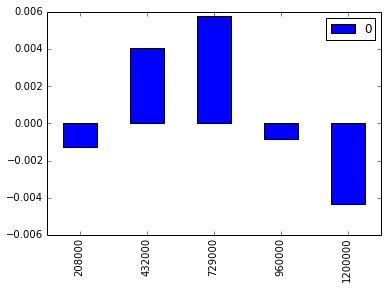

In [26]:
index = sorted(mean_diffs.keys())
pd.DataFrame([mean_diffs[f] for f in index], index=index).plot(kind='bar')

In [36]:
executor.experiments[0].out_dir

'/home/brejac01/sources/lisa/results/20170315_123837/rtapp:freq_208000:break_packing/1'